In [35]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import rdmolops
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam

In [36]:
file = pd.read_csv(r"C:\Users\dharu\OneDrive\Desktop\7th Sem\High Performance Computing\DDH Data.csv")
file2 = pd.read_csv(r"C:\Users\dharu\OneDrive\Desktop\7th Sem\High Performance Computing\DDH Data with Properties.csv")

In [37]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Compound No.            104 non-null    int64  
 1   SMILES                  104 non-null    object 
 2   pIC50 (IC50 in microM)  104 non-null    object 
 3   Unnamed: 3              0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.4+ KB


In [38]:
file = file[file['pIC50 (IC50 in microM)'] != 'BLINDED']
file = file.drop("Unnamed: 3", axis=1)

In [39]:
file = pd.merge(file, file2, on='SMILES', how='left')

In [40]:
file = file.drop(['Compound No.', 'pIC50 (IC50 in microM)', 'CID', 'MolecularFormula', 'InChI', 'InChIKey', 'IUPACName'], axis=1)

In [41]:
file['pIC50'] = pd.to_numeric(file['pIC50'], errors='coerce')  
file.dropna(subset=['pIC50'], inplace=True)

In [42]:
features = file.drop(['pIC50','SMILES'],axis=1)
target = file['pIC50']
mask = ~np.isnan(features).any(axis=1)
features = features[mask]
target = target[mask].reset_index(drop=True)

In [43]:
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(features)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2212)

In [53]:
comp = []
max_nodes = max(rdmolops.GetAdjacencyMatrix(Chem.MolFromSmiles(smi)).shape[0] for smi in file["SMILES"])

for smi in file["SMILES"]:
    mol = Chem.MolFromSmiles(smi)
    adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
    padded_adj = np.pad(adj_matrix, ((0, max_nodes - adj_matrix.shape[0]), (0, max_nodes - adj_matrix.shape[1])), mode='constant')
    comp.append(padded_adj)


In [54]:
comp = np.array(comp)

In [57]:
max_nodes = max(adj.shape[0] for adj in comp)  
padded_adj_matrices = np.array([np.pad(adj, ((0, max_nodes - adj.shape[0]), (0, max_nodes - adj.shape[1])), mode='constant') for adj in comp])
padded_adj_matrices = padded_adj_matrices[:91]

In [58]:
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(padded_adj_matrices, target, test_size=0.2, random_state=42)

In [49]:
class GraphConvLayer(layers.Layer):
    def __init__(self, output_dim):
        super(GraphConvLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", (input_shape[-1], self.output_dim))  

    def call(self, adj):
        num_nodes = tf.shape(adj)[-1]
        identity_features = tf.eye(num_nodes)  
        features = tf.matmul(identity_features, self.kernel)  
        output = tf.matmul(adj, features)  
        return tf.nn.relu(output)  

In [59]:
def build_gcn_model(input_shape):
    adj_input = layers.Input(shape=input_shape)  
    x = GraphConvLayer(64)(adj_input)  
    x = layers.Dropout(0.5)(x)

    x = GraphConvLayer(32)(x)  
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling1D()(x)  
    output = layers.Dense(1)(x)

    model = models.Model(inputs=adj_input, outputs=output)
    return model

In [60]:
input_shape = (max_nodes, max_nodes)  
gcn_model = build_gcn_model(input_shape)
gcn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_gcn = gcn_model.fit(X_train_adj, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


C:\Users\dharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2/2 [==============================] - 1s 240ms/step - loss: 1.6633 - mae: 1.1127 - val_loss: 1.1835 - val_mae: 1.0758
Epoch 2/10
2/2 [==============================] - 0s 32ms/step - loss: 1.6047 - mae: 1.0877 - val_loss: 1.1089 - val_mae: 1.0401
Epoch 3/10
2/2 [==============================] - 0s 26ms/step - loss: 1.5365 - mae: 1.0675 - val_loss: 1.0375 - val_mae: 1.0047
Epoch 4/10
2/2 [==============================] - 0s 34ms/step - loss: 1.4950 - mae: 1.0449 - val_loss: 0.9679 - val_mae: 0.9689
Epoch 5/10
2/2 [==============================] - 0s 30ms/step - loss: 1.4322 - mae: 1.0226 - val_loss: 0.9000 - val_mae: 0.9326
Epoch 6/10
2/2 [==============================] - 0s 33ms/step - loss: 1.3940 - mae: 1.0098 - val_loss: 0.8338 - val_mae: 0.8958
Epoch 7/10
2/2 [==============================] - 0s 30ms/step - loss: 1.3629 - mae: 0.9948 - val_loss: 0.7688 - val_mae: 0.8580
Epoch 8/10
2/2 [==============================] - 0s 29ms/step - loss: 1.2962 - mae: 0.9620 - val_loss: 0.7

In [61]:
def build_fcnn_model(input_shape):
    input_layer = layers.Input(shape=(input_shape,))
    x = layers.Dense(64, activation='relu')(input_layer)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(1)(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

In [62]:
input_shape_features = X_train.shape[1]
fcnn_model = build_fcnn_model(input_shape_features)
optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)
fcnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_fcnn = fcnn_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1)

Epoch 1/1000
2/2 [==============================] - 1s 125ms/step - loss: 22513.6035 - mae: 127.9508 - val_loss: 8472.1855 - val_mae: 91.6788
Epoch 2/1000
2/2 [==============================] - 0s 26ms/step - loss: 18379.9922 - mae: 111.2581 - val_loss: 4404.7705 - val_mae: 65.9550
Epoch 3/1000
2/2 [==============================] - 0s 30ms/step - loss: 10155.1992 - mae: 83.8853 - val_loss: 1856.1077 - val_mae: 42.3696
Epoch 4/1000
2/2 [==============================] - 0s 30ms/step - loss: 6088.4761 - mae: 66.2020 - val_loss: 547.9772 - val_mae: 21.7242
Epoch 5/1000
2/2 [==============================] - 0s 30ms/step - loss: 7532.0195 - mae: 72.8173 - val_loss: 115.1567 - val_mae: 9.3354
Epoch 6/1000
2/2 [==============================] - 0s 25ms/step - loss: 4324.9399 - mae: 49.1638 - val_loss: 182.2297 - val_mae: 10.2744
Epoch 7/1000
2/2 [==============================] - 0s 24ms/step - loss: 6718.1094 - mae: 63.8293 - val_loss: 369.0471 - val_mae: 16.3384
Epoch 8/1000
2/2 [========

In [27]:
fcnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                2176      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [42]:
gcn_loss, gcn_mae = gcn_model.evaluate(X_test_adj, y_test)
fcnn_loss, fcnn_mae = fcnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 29ms/step - loss: 1.5260 - mae: 1.0649


In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models

def combine_models(gcn_model, fcnn_model):
    gcn_output = gcn_model.output
    fcnn_output = fcnn_model.output
    w1 = tf.Variable(0.5, trainable=True, dtype=tf.float32, name='weight1')
    w2 = tf.Variable(0.5, trainable=True, dtype=tf.float32, name='weight2')

    combined_output = layers.Lambda(lambda x: w1 * x[0] + w2 * x[1])([gcn_output, fcnn_output])
    final_output = layers.Dense(1)(combined_output)
    combined_model = models.Model(inputs=[gcn_model.input, fcnn_model.input], outputs=final_output)
    return combined_model


In [62]:
combined_model = combine_models(gcn_model, fcnn_model)

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'weight1:0' shape=() dtype=float32>
  <tf.Variable 'weight2:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [63]:
combined_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [64]:
min_samples = min(X_train_adj.shape[0], X_train.shape[0], y_train.shape[0])
X_train_adj = X_train_adj[:min_samples]
X_train = X_train[:min_samples]
y_train = y_train[:min_samples]

history_combined = combined_model.fit([X_train_adj, X_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\dharu\AppData\Local\Temp\ipykernel_2396\1514356178.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y_train[:min_samples]
C:\Users\dharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2/2 [==============================] - 1s 214ms/step - loss: 6.3182 - mae: 2.2845 - val_loss: 2.5459 - val_mae: 1.5228
Epoch 2/10
2/2 [==============================] - 0s 45ms/step - loss: 3.5456 - mae: 1.6733 - val_loss: 1.2214 - val_mae: 1.0379
Epoch 3/10
2/2 [==============================] - 0s 51ms/step - loss: 2.8617 - mae: 1.4992 - val_loss: 0.6070 - val_mae: 0.6857
Epoch 4/10
2/2 [==============================] - 0s 42ms/step - loss: 2.0869 - mae: 1.2315 - val_loss: 0.4005 - val_mae: 0.5426
Epoch 5/10
2/2 [==============================] - 0s 41ms/step - loss: 1.5479 - mae: 1.0062 - val_loss: 0.3543 - val_mae: 0.4856
Epoch 6/10
2/2 [==============================] - 0s 49ms/step - loss: 1.7720 - mae: 1.0100 - val_loss: 0.3507 - val_mae: 0.4837
Epoch 7/10
2/2 [==============================] - 0s 41ms/step - loss: 1.8069 - mae: 1.0905 - val_loss: 0.3868 - val_mae: 0.5288
Epoch 8/10
2/2 [==============================] - 0s 51ms/step - loss: 1.7815 - mae: 1.0160 - val_loss: 0.4

In [65]:
import matplotlib.pyplot as plt

In [66]:
def plot_metrics(history_gcn, history_fcnn, history_combined):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_gcn.history['loss'], label='GCN Train Loss')
    plt.plot(history_gcn.history['val_loss'], label='GCN Validation Loss')
    plt.title('GCN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_fcnn.history['loss'], label='FCN Train Loss')
    plt.plot(history_fcnn.history['val_loss'], label='FCN Validation Loss')
    plt.title('FCN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(history_combined.history['loss'], label='Combined Train Loss')
    plt.plot(history_combined.history['val_loss'], label='Combined Validation Loss')
    plt.title('Combined Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [67]:
def plot_mae(history_gcn, history_fcnn, history_combined):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_gcn.history['mae'], label='GCN Train MAE')
    plt.plot(history_gcn.history['val_mae'], label='GCN Validation MAE')
    plt.title('GCN MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_fcnn.history['mae'], label='FCN Train MAE')
    plt.plot(history_fcnn.history['val_mae'], label='FCN Validation MAE')
    plt.title('FCN MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(7, 5))
    plt.plot(history_combined.history['mae'], label='Combined Train MAE')
    plt.plot(history_combined.history['val_mae'], label='Combined Validation MAE')
    plt.title('Combined Model MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()


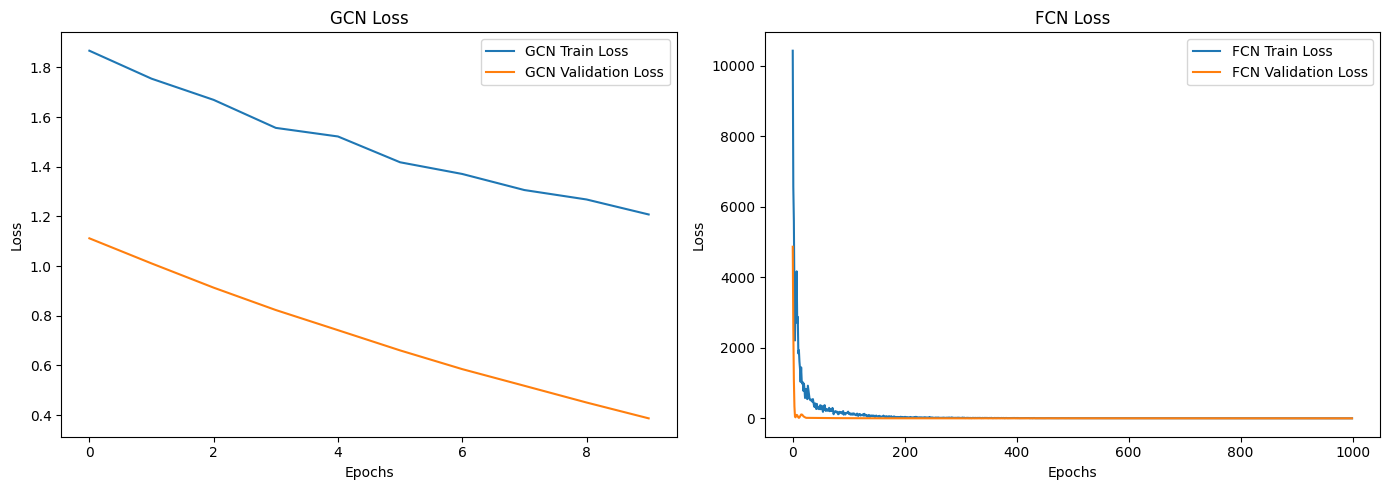

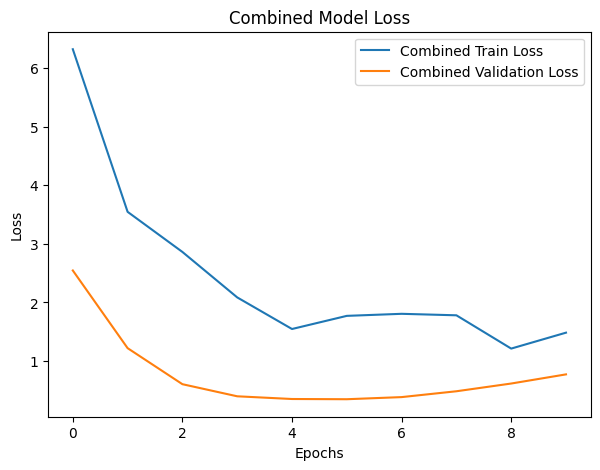

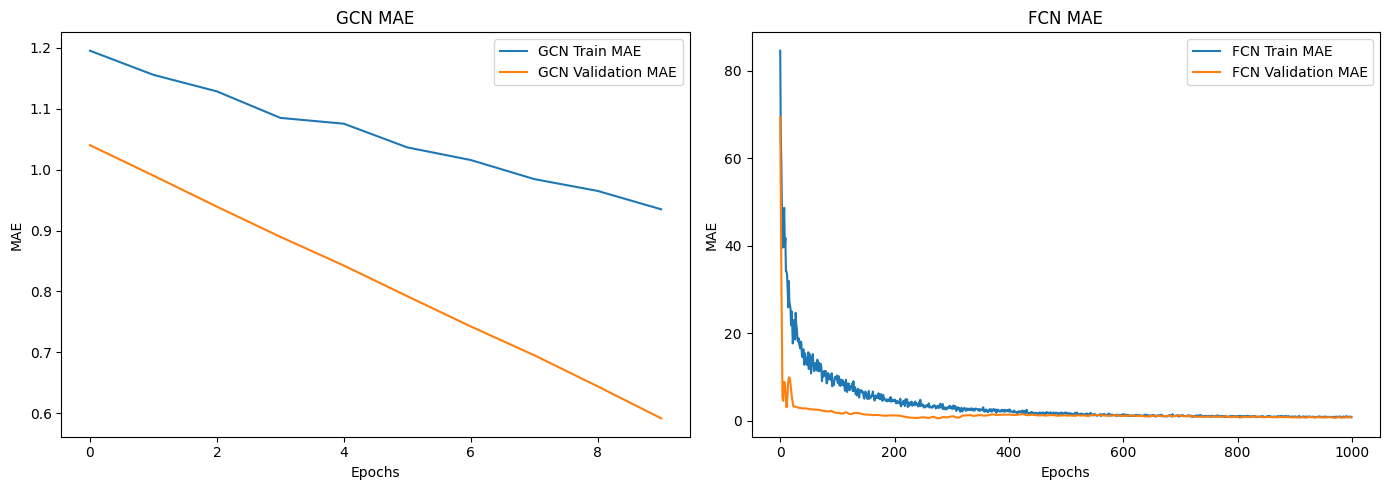

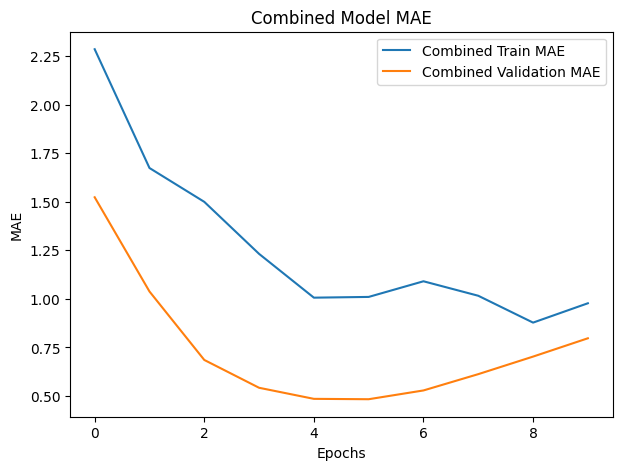

In [68]:
plot_metrics(history_gcn, history_fcnn, history_combined)
plot_mae(history_gcn, history_fcnn, history_combined)

In [69]:
combined_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 39, 39)]     0           []                               
                                                                                                  
 graph_conv_layer (GraphConvLay  (None, 39, 64)      2496        ['input_1[0][0]']                
 er)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 39, 64)       0           ['graph_conv_layer[0][0]']       
                                                                                                  
 input_7 (InputLayer)           [(None, 33)]         0           []                         

In [64]:
%pip install --upgrade --force-reinstall tensorflow
%pip install -U tensorflow tensorflow-intel tensorflow-io-gcs-filesystem

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\dharu\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\~rapt\\_wrappers.cp310-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\dharu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/59/63/5ca1b06cf17dda9c52927917a7911612953a7d91865b1288c7f9eac2b53b/tensorflow-2.18.0-cp310-cp310-win_amd64.whl.metadata
  Using cached tensorflow-2.18.0-cp310-cp310-win_amd64.whl.metadata (3.3 kB)
  Obtaining dependency information for tensorflow-intel==2.18.0 from https://files.pythonhosted.org/packages/b2/47/e1a7cc95eccaaa52f47c3de8fd81abcfce105979790892f52e745339f929/tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.18.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\dharu\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\dharu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [91]:
import tensorflow as tf

class EnsembleModel(tf.keras.Model):
    def __init__(self, model1, model2, uncertainty_coefficient_model1, uncertainty_coefficient_model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.uncertainty_coefficient_model1 = uncertainty_coefficient_model1
        self.uncertainty_coefficient_model2 = uncertainty_coefficient_model2

    def call(self, inputs):
        adj_matrix, features = inputs  
        output1 = self.model1(adj_matrix)  
        output2 = self.model2(features)
    
        combined_output = (
            self.uncertainty_coefficient_model1 * output1 + 
            self.uncertainty_coefficient_model2 * output2
        ) / (self.uncertainty_coefficient_model1 + self.uncertainty_coefficient_model2)
        
        return combined_output


In [92]:
uncertainty_coefficient_model1 = 0.5  
uncertainty_coefficient_model2 = 0.5  
ensemble_model = EnsembleModel(gcn_model, fcnn_model, uncertainty_coefficient_model1, uncertainty_coefficient_model2)

In [93]:
ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [95]:
history_ensemble = ensemble_model.fit(
    [X_train_adj, X_train],  
    y_train,
    epochs=20,              
    batch_size=32,           
    validation_split=0.2,    
    verbose=1
)


Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 1.6915 - mae: 1.0858

C:\Users\dharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2/2 [==============================] - 0s 109ms/step - loss: 1.6829 - mae: 1.0663 - val_loss: 0.9412 - val_mae: 0.8365
Epoch 2/20
2/2 [==============================] - 0s 40ms/step - loss: 1.6845 - mae: 1.1142 - val_loss: 0.6576 - val_mae: 0.6771
Epoch 3/20
2/2 [==============================] - 0s 31ms/step - loss: 1.1750 - mae: 0.8949 - val_loss: 0.3837 - val_mae: 0.4851
Epoch 4/20
2/2 [==============================] - 0s 38ms/step - loss: 1.2868 - mae: 0.9276 - val_loss: 0.3385 - val_mae: 0.4581
Epoch 5/20
2/2 [==============================] - 0s 33ms/step - loss: 1.4949 - mae: 1.0169 - val_loss: 0.3623 - val_mae: 0.4942
Epoch 6/20
2/2 [==============================] - 0s 33ms/step - loss: 1.3694 - mae: 1.0027 - val_loss: 0.5751 - val_mae: 0.5977
Epoch 7/20
2/2 [==============================] - 0s 31ms/step - loss: 1.0857 - mae: 0.8355 - val_loss: 0.7083 - val_mae: 0.6704
Epoch 8/20
2/2 [==============================] - 0s 42ms/step - loss: 1.2869 - mae: 0.9636 - val_loss: 0.5

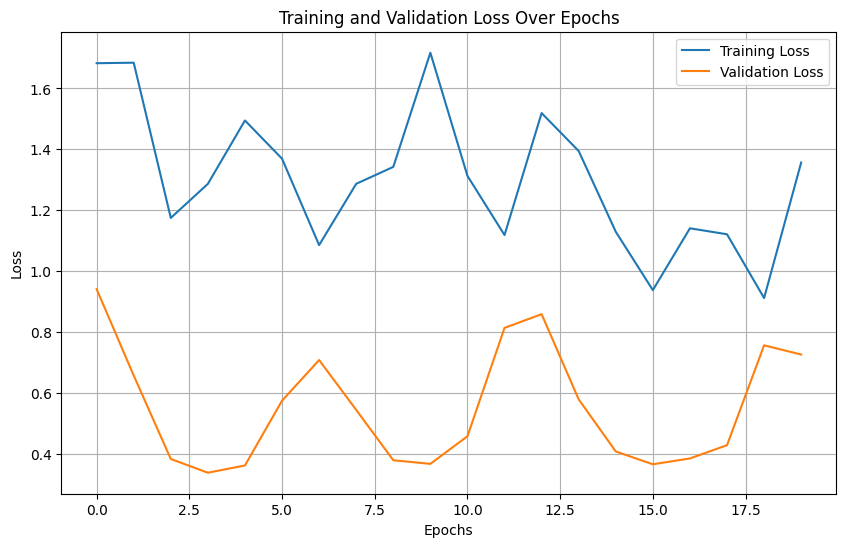

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(history_ensemble.history['loss'], label='Training Loss')
plt.plot(history_ensemble.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

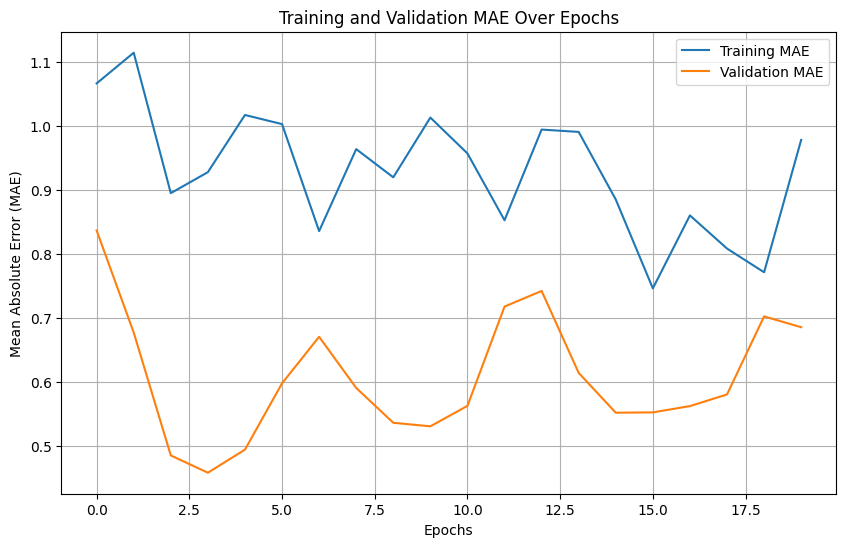

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(history_ensemble.history['mae'], label='Training MAE')
plt.plot(history_ensemble.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
final_train_loss = history_ensemble.history['loss'][-1]
final_val_loss = history_ensemble.history['val_loss'][-1]
final_train_mae = history_ensemble.history['mae'][-1]
final_val_mae = history_ensemble.history['val_mae'][-1]

In [102]:
best_epoch = min(range(len(history_ensemble.history['val_mae'])), key=lambda i: history_ensemble.history['val_mae'][i])
best_val_mae = history_ensemble.history['val_mae'][best_epoch]

In [104]:
print("Training Summary for UncerGCN-FCN:")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Best Validation MAE at Epoch {best_epoch + 1}: {best_val_mae:.4f}")

Training Summary for UncerGCN-FCN:
Final Training Loss: 1.3568
Final Validation Loss: 0.7265
Final Training MAE: 0.9781
Final Validation MAE: 0.6854
Best Validation MAE at Epoch 4: 0.4581


In [105]:
final_train_loss = history_gcn.history['loss'][-1]
final_val_loss = history_gcn.history['val_loss'][-1]
final_train_mae = history_gcn.history['mae'][-1]
final_val_mae = history_gcn.history['val_mae'][-1]

In [106]:
print("Training Summary for Graph Convulutional Network:")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Best Validation MAE at Epoch {best_epoch + 1}: {best_val_mae:.4f}")

Training Summary for Graph Convulutional Network:
Final Training Loss: 1.2267
Final Validation Loss: 0.5871
Final Training MAE: 0.9270
Final Validation MAE: 0.7419
Best Validation MAE at Epoch 4: 0.4581


In [109]:
final_train_loss = history_fcnn.history['loss'][-1]
final_val_loss = history_fcnn.history['val_loss'][-1]
final_train_mae = history_fcnn.history['mae'][-1]
final_val_mae = history_fcnn.history['val_mae'][-1]

In [110]:
print("Training Summary for Full Connected Neural Network:")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Best Validation MAE at Epoch {best_epoch + 1}: {best_val_mae:.4f}")

Training Summary for Full Connected Neural Network:
Final Training Loss: 2.5963
Final Validation Loss: 0.8588
Final Training MAE: 1.1896
Final Validation MAE: 0.7429
Best Validation MAE at Epoch 4: 0.4581


In [111]:
ensemble_model.summary()

Model: "ensemble_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1)                 4577      
                                                                 
 model_3 (Functional)        (None, 1)                 4289      
                                                                 
Total params: 8,866
Trainable params: 8,866
Non-trainable params: 0
_________________________________________________________________


In [112]:
gcn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 39, 39)]          0         
                                                                 
 graph_conv_layer_4 (GraphCo  (None, 39, 64)           2496      
 nvLayer)                                                        
                                                                 
 dropout_4 (Dropout)         (None, 39, 64)            0         
                                                                 
 graph_conv_layer_5 (GraphCo  (None, 39, 32)           2048      
 nvLayer)                                                        
                                                                 
 dropout_5 (Dropout)         (None, 39, 32)            0         
                                                                 
 global_average_pooling1d_2   (None, 32)               0   